## Plot survival prediction results

In this notebook, we'll compare the results of survival prediction using [elastic net Cox regression](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html) for expression and methylation data only.

The files analyzed in this notebook are generated by the `run_survival_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff for pairwise comparisons (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
SAVE_FIGS = True

In [3]:
# set results directory
me_results_dir = Path(cfg.repo_root,
                      '06_predict_survival',
                      'results_extended_alphas',
                      'results_5000_pca').resolve()
me_results_desc = 'top 5000 PCs'

# set images directory
images_dir = Path(cfg.images_dirs['survival'])

# load results into a single dataframe
me_results_df = su.load_survival_results(me_results_dir)
me_results_df.rename(columns={'identifier': 'cancer_type',
                              'fold_no': 'fold'}, inplace=True)
me_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.98206,train,UVM,me_27k,signal,42,0
1,0.98206,cv,UVM,me_27k,signal,42,0
2,0.75490,test,UVM,me_27k,signal,42,0
3,0.93543,train,UVM,me_27k,signal,42,1
4,0.93543,cv,UVM,me_27k,signal,42,1


### Check model convergence results

In the past we were having issues with model convergence for some cancer types. Let's see how frequently (if at all) this is happening.

In [4]:
me_count_df = (me_results_df[me_results_df.data_type == 'test']
    .groupby(['cancer_type', 'training_data'])
    .count()
)
problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
print(len(problem_df), '/', len(me_count_df))
problem_df

19 / 99


cindex  data_type  signal  seed  fold
cancer_type training_data                                       
ACC         me_27k             12         12      12    12    12
CHOL        expression         12         12      12    12    12
            me_27k              8          8       8     8     8
            me_450k            12         12      12    12    12
DLBC        expression          4          4       4     4     4
            me_27k              4          4       4     4     4
            me_450k             4          4       4     4     4
KICH        expression          8          8       8     8     8
            me_27k              8          8       8     8     8
            me_450k             8          8       8     8     8
PCPG        expression         12         12      12    12    12
READ        expression          8          8       8     8     8
            me_27k             12         12      12    12    12
TGCT        me_27k             12         12      12    12    12
            me_450k             4          4       4     4     4
THCA        expression         12         12      12    12    12
THYM        me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
UCS         expression          8          8       8     8     8

We'll just drop these missing cancer types from our comparisons for now, although we could debug the issues with model convergence sometime in the future (e.g. by using an extended parameter range).

In [5]:
drop_cancer_types = problem_df.index.get_level_values(0).unique().values
print(drop_cancer_types)

['ACC' 'CHOL' 'DLBC' 'KICH' 'PCPG' 'READ' 'TGCT' 'THCA' 'THYM' 'UCS']


### Plot survival prediction results

We want to compare survival prediction for:
* true labels vs. shuffled labels
* between omics types
    
As a metric, for now we're just using the [censored concordance index](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.metrics.concordance_index_censored.html). Essentially, this compares the actual order of events (i.e. death or tumor progression) in the test dataset vs. the order of events predicted by the model in the test samples. A higher concordance index = better prediction.

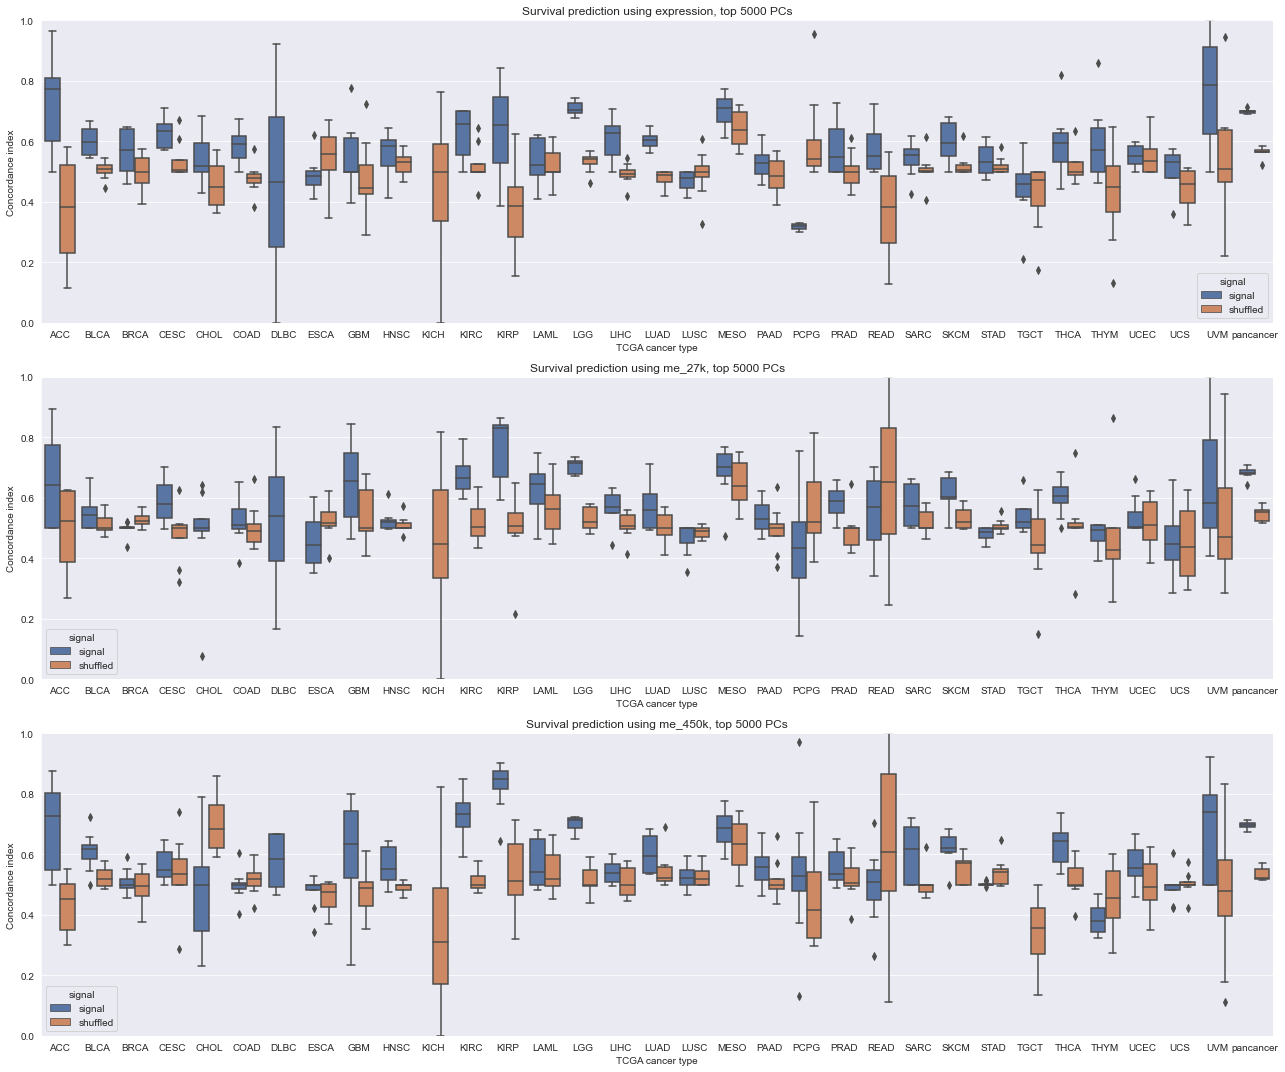

In [6]:
sns.set({'figure.figsize': (18, 15)})
fig, axarr = plt.subplots(3, 1)

for ix, data_type in enumerate(
    me_results_df.training_data.sort_values().unique()
):
    
    ax = axarr[ix]
    
    filtered_df = me_results_df[
        (me_results_df.training_data == data_type) &
        (me_results_df.data_type == 'test')
    ].copy()

    filtered_df.sort_values(by='cancer_type', inplace=True)

    sns.boxplot(data=filtered_df, x='cancer_type', y='cindex', hue='signal',
                hue_order=['signal', 'shuffled'], ax=ax)
    ax.set_xlabel('TCGA cancer type')
    ax.set_ylabel('Concordance index')
    ax.set_title('Survival prediction using {}, {}'.format(data_type,
                                                           me_results_desc))
    ax.set_ylim(0.0, 1.0)
    
plt.tight_layout()

In [7]:
me_results_df['identifier'] = (me_results_df.cancer_type + '_' +
                               me_results_df.training_data)
me_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold,identifier
0,0.98206,train,UVM,me_27k,signal,42,0,UVM_me_27k
1,0.98206,cv,UVM,me_27k,signal,42,0,UVM_me_27k
2,0.75490,test,UVM,me_27k,signal,42,0,UVM_me_27k
3,0.93543,train,UVM,me_27k,signal,42,1,UVM_me_27k
4,0.93543,cv,UVM,me_27k,signal,42,1,UVM_me_27k


In [8]:
me_compare_df = au.compare_control_ind(me_results_df,
                                       identifier='identifier',
                                       metric='cindex',
                                       verbose=True)
me_compare_df['cancer_type'] = me_compare_df.identifier.str.split('_', 1, expand=True)[0]
me_compare_df['training_data'] = me_compare_df.identifier.str.split('_', 1, expand=True)[1]

print(len(me_compare_df))
me_compare_df.head()

shapes unequal for ACC_me_27k, skipping
shapes unequal for CHOL_expression, skipping
shapes unequal for CHOL_me_27k, skipping
shapes unequal for CHOL_me_450k, skipping
shapes unequal for DLBC_expression, skipping
shapes unequal for DLBC_me_27k, skipping
shapes unequal for DLBC_me_450k, skipping
shapes unequal for KICH_expression, skipping
shapes unequal for KICH_me_27k, skipping
shapes unequal for KICH_me_450k, skipping
shapes unequal for PCPG_expression, skipping
shapes unequal for READ_me_27k, skipping
shapes unequal for TGCT_me_27k, skipping
shapes unequal for TGCT_me_450k, skipping
shapes unequal for THCA_expression, skipping


648


shapes unequal for THYM_me_27k, skipping
shapes unequal for THYM_me_450k, skipping


,identifier,seed,fold,delta_cindex,cancer_type,training_data
0,ACC_expression,42,0,0.25904,ACC,expression
1,ACC_expression,42,1,0.72391,ACC,expression
2,ACC_expression,42,2,0.26161,ACC,expression
3,ACC_expression,42,3,0.43228,ACC,expression
4,ACC_expression,1,0,0.44123,ACC,expression


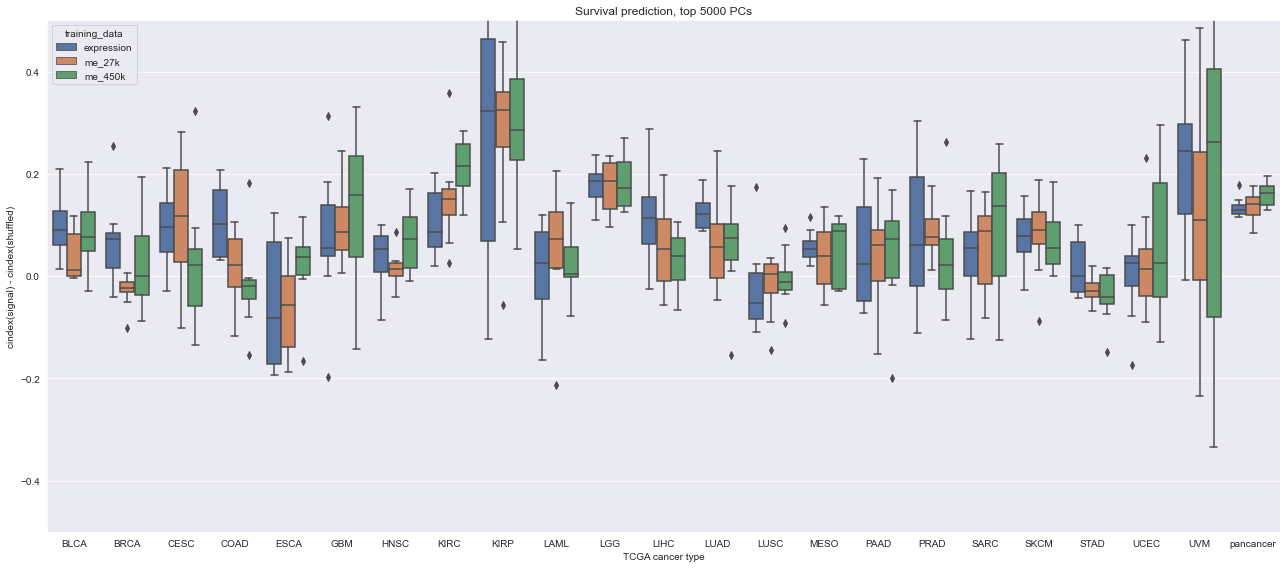

In [9]:
sns.set({'figure.figsize': (18, 8)})
    
me_compare_df.sort_values(by='cancer_type', inplace=True)

sns.boxplot(data=me_compare_df[~me_compare_df.cancer_type.isin(drop_cancer_types)],
            x='cancer_type',
            y='delta_cindex',
            hue='training_data',
            hue_order=sorted(me_compare_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Survival prediction, {}'.format(me_results_desc))
plt.ylim(-0.5, 0.5)
    
plt.tight_layout()

### Heatmap

Heatmap

In [10]:
me_all_results_df = au.compare_all_data_types(me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
                                           SIG_ALPHA,
                                           identifier='cancer_type',
                                           metric='cindex')

me_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
me_all_results_df.sort_values(by='p_value').head(10)

,cancer_type,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
22,pancancer,0.160496,3.018287e-07,0.000007,True,me_450k,5.158512
22,pancancer,0.135211,3.154299e-07,0.000007,True,expression,5.139369
22,pancancer,0.135767,4.793854e-06,0.000110,True,me_27k,3.957587
10,LGG,0.177524,6.001378e-06,0.000069,True,expression,4.161051
7,KIRC,0.213374,1.667704e-05,0.000192,True,me_450k,3.717183
12,LUAD,0.124625,2.049806e-05,0.000157,True,expression,3.803681
10,LGG,0.183414,3.239143e-05,0.000248,True,me_450k,3.604963
10,LGG,0.174691,4.214596e-05,0.000485,True,me_27k,3.314546
8,KIRP,0.296839,6.944904e-04,0.003993,True,me_450k,2.398666
14,MESO,0.058138,1.254750e-03,0.007215,True,expression,2.141775


In [11]:
me_heatmap_df = (me_all_results_df
    .pivot(index='training_data', columns='cancer_type', values='delta_mean')
    .reindex(sorted(me_compare_df.training_data.unique()))
)
me_heatmap_df.iloc[:, :5]

cancer_type,BLCA,BRCA,CESC,COAD,ESCA
training_data,,,,,
expression,0.096554,0.069850,0.090910,0.107509,-0.053459
me_27k,0.038526,-0.029045,0.108960,0.014830,-0.065069
me_450k,0.085079,0.023825,0.025118,-0.017249,0.017307


In [12]:
raw_results_df = (me_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
)
raw_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.98206,train,UVM,me_27k,signal,42,0
1,0.98206,cv,UVM,me_27k,signal,42,0
2,0.75490,test,UVM,me_27k,signal,42,0
3,0.93543,train,UVM,me_27k,signal,42,1
4,0.93543,cv,UVM,me_27k,signal,42,1


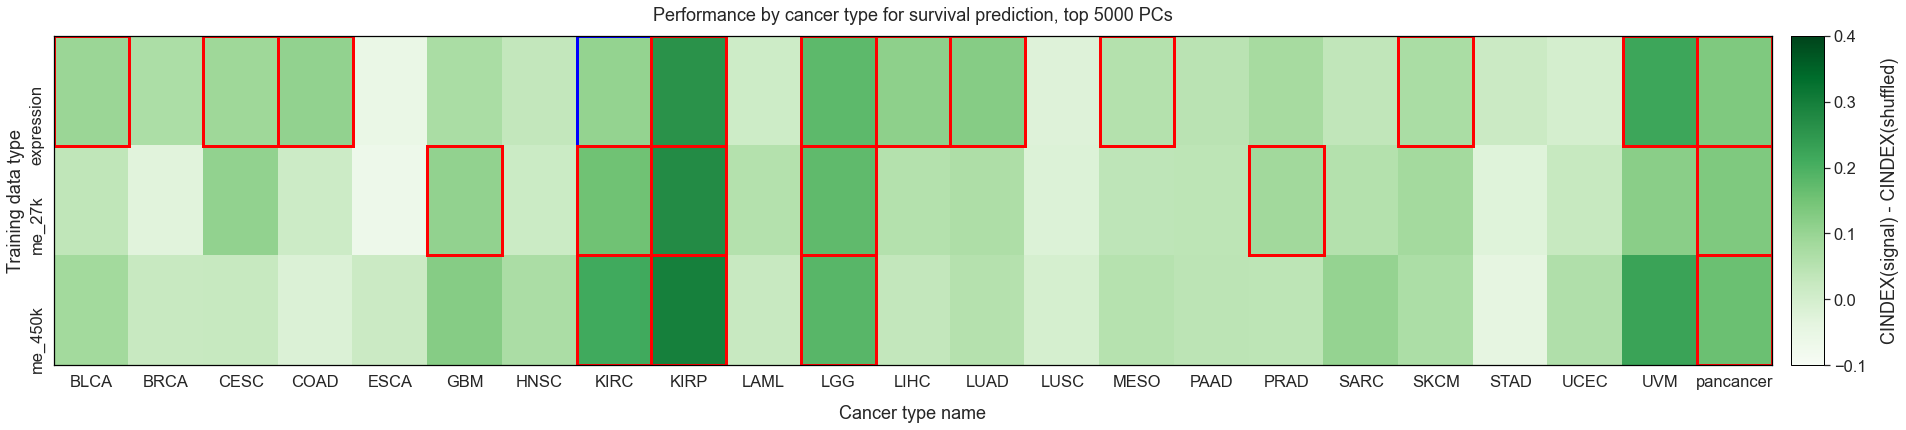

In [13]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(me_heatmap_df,
                      me_all_results_df.reset_index(drop=True),
                      different_from_best=True,
                      raw_results_df=raw_results_df,
                      metric='cindex',
                      id_name='cancer_type',
                      scale=(-0.1, 0.4))

plt.title('Performance by cancer type for survival prediction, {}'.format(me_results_desc), pad=15)
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'survival_me_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'survival_me_boxes.png',
                dpi=300, bbox_inches='tight')

### Same thing, but for all data types